# Tutorial 4 - Advanced Image Processing

Heavily based on following tutorials:
 - [Original Notebook](https://github.com/azad-academy/denoising-diffusion-model/blob/main/diffusion_model_demo.ipynb)
   - [Repository](https://github.com/azad-academy/denoising-diffusion-model)
   - [Medium Tutorial](https://towardsdatascience.com/diffusion-models-made-easy-8414298ce4da)
 - https://learnopencv.com/denoising-diffusion-probabilistic-models/

In the tutorials we will explore Difusion Denoising Models which are basis for Stable Diffusion Models.

In the first part, we will demonstrate noising and de-noising process and the ability to learn the denoising process.

## Diffusion on Synthetic Data

A denoising diffusion modeling is a two step process: the forward diffusion process and the reverse process or the reconstruction. In the forward diffusion process, gaussian noise is introduced successively until the data becomes all noise. The reverse/ reconstruction process undoes the noise by learning the conditional probability densities using a neural network model.

![diffusion-image](diffusion.png)

The forward pass represents **gradual** introduction of white noise into the picture. In each noising iteration we will introduce additional noise (in comparison to previous iteration).

$q(x_t | x_{t-1}) = N(x_{t} ; \sqrt{1 - \beta_t} x_{t-1}, \beta_t)$

with few additional rewritings, you can arrive to

$q(x_t | x_0) = N(x_{t} ; \sqrt{\alpha_t} x_0, (1 - \alpha_t))$

representing the cummulative noise from begining to time-step $t$. 

The $\beta_t$ represents the "amount" of noise added into the picture. In our example, it will represent the alteration in the position of individual data points.

In order to run the notebook, you need to install following depandancies:

`pip3 install jupyter matplotlib numpy scikit-learn torch`

In [9]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_checkerboard,make_circles,make_moons,make_s_curve,make_swiss_roll
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [10]:
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas

def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)

def q_posterior_mean_variance(x_0, x_t, t,posterior_mean_coef_1,posterior_mean_coef_2,posterior_log_variance_clipped):
    coef_1 = extract(posterior_mean_coef_1, t, x_0)
    coef_2 = extract(posterior_mean_coef_2, t, x_0)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, x_0)
    return mean, var

def p_mean_variance(model, x, t):
    # Go through model
    out = model(x, t)
    # Extract the mean and variance
    mean, log_var = torch.split(out, 2, dim=-1)
    var = torch.exp(log_var)
    return mean, log_var

def p_sample(model, x, t,alphas,betas,one_minus_alphas_bar_sqrt):
    t = torch.tensor([t])
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x))
    # Model output
    eps_theta = model(x, t)
    # Final values
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
    # Generate z
    z = torch.randn_like(x)
    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt()
    sample = mean + sigma_t * z
    return (sample)

def p_sample_loop(model, shape,n_steps,alphas,betas,one_minus_alphas_bar_sqrt):
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i,alphas,betas,one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

def approx_standard_normal_cdf(x):
    return 0.5 * (1.0 + torch.tanh(torch.tensor(np.sqrt(2.0 / np.pi)) * (x + 0.044715 * torch.pow(x, 3))))

def discretized_gaussian_log_likelihood(x, means, log_scales):
    # Assumes data is integers [0, 255] rescaled to [-1, 1]
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = approx_standard_normal_cdf(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = approx_standard_normal_cdf(min_in)
    log_cdf_plus = torch.log(torch.clamp(cdf_plus, min=1e-12))
    log_one_minus_cdf_min = torch.log(torch.clamp(1 - cdf_min, min=1e-12))
    cdf_delta = cdf_plus - cdf_min
    log_probs = torch.where(x < -0.999, log_cdf_plus, torch.where(x > 0.999, log_one_minus_cdf_min, torch.log(torch.clamp(cdf_delta, min=1e-12))))
    return log_probs

def normal_kl(mean1, logvar1, mean2, logvar2):
    kl = 0.5 * (-1.0 + logvar2 - logvar1 + torch.exp(logvar1 - logvar2) + ((mean1 - mean2) ** 2) * torch.exp(-logvar2))
    return kl

def q_sample(x_0, t, alphas_bar_sqrt, one_minus_alphas_bar_sqrt ,noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

def loss_variational(model, x_0,alphas_bar_sqrt, one_minus_alphas_bar_sqrt,posterior_mean_coef_1,posterior_mean_coef_2,posterior_log_variance_clipped,n_steps):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # Perform diffusion for step t
    x_t = q_sample(x_0, t, alphas_bar_sqrt, one_minus_alphas_bar_sqrt)
    # Compute the true mean and variance
    true_mean, true_var = q_posterior_mean_variance(x_0, x_t, t,posterior_mean_coef_1,posterior_mean_coef_2,posterior_log_variance_clipped)
    # Infer the mean and variance with our model
    model_mean, model_var = p_mean_variance(model, x_t, t)
    # Compute the KL loss
    kl = normal_kl(true_mean, true_var, model_mean, model_var)
    kl = torch.mean(kl.view(batch_size, -1), dim=1) / np.log(2.)
    # NLL of the decoder
    decoder_nll = -discretized_gaussian_log_likelihood(x_0, means=model_mean, log_scales=0.5 * model_var)
    decoder_nll = torch.mean(decoder_nll.view(batch_size, -1), dim=1) / np.log(2.)
    # At the first timestep return the decoder NLL, otherwise return KL(q(x_{t-1}|x_t,x_0) || p(x_{t-1}|x_t))
    output = torch.where(t == 0, decoder_nll, kl)
    return output.mean(-1)

def noise_estimation_loss(model, x_0,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,n_steps):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # x0 multiplier
    a = extract(alphas_bar_sqrt, t, x_0)
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0)
    e = torch.randn_like(x_0)
    # model input
    x = x_0 * a + e * am1
    output = model(x, t)
    return (e - output).square().mean()

def hdr_plot_style():
    plt.style.use('dark_background')
    mpl.rcParams.update({'font.size': 18, 'lines.linewidth': 3, 'lines.markersize': 15})
    # avoid type 3 (i.e. bitmap) fonts in figures
    mpl.rcParams['ps.useafm'] = True
    mpl.rcParams['pdf.use14corefonts'] = True
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams['font.family'] = 'sans-serif'
    mpl.rcParams['font.sans-serif'] = 'Courier New'
    # mpl.rcParams['text.hinting'] = False
    # Set colors cycle
    colors = mpl.cycler('color', ['#3388BB', '#EE6666', '#9988DD', '#EECC55', '#88BB44', '#FFBBBB'])
    #plt.rc('figure', facecolor='#00000000', edgecolor='black')
    #plt.rc('axes', facecolor='#FFFFFF88', edgecolor='white', axisbelow=True, grid=True, prop_cycle=colors)
    plt.rc('legend', facecolor='#666666EE', edgecolor='white', fontsize=16)
    plt.rc('grid', color='white', linestyle='solid')
    plt.rc('text', color='white')
    plt.rc('xtick', direction='out', color='white')
    plt.rc('ytick', direction='out', color='white')
    plt.rc('patch', edgecolor='#E6E6E6')


### Define and Plot the Synthetic Shapes

[]

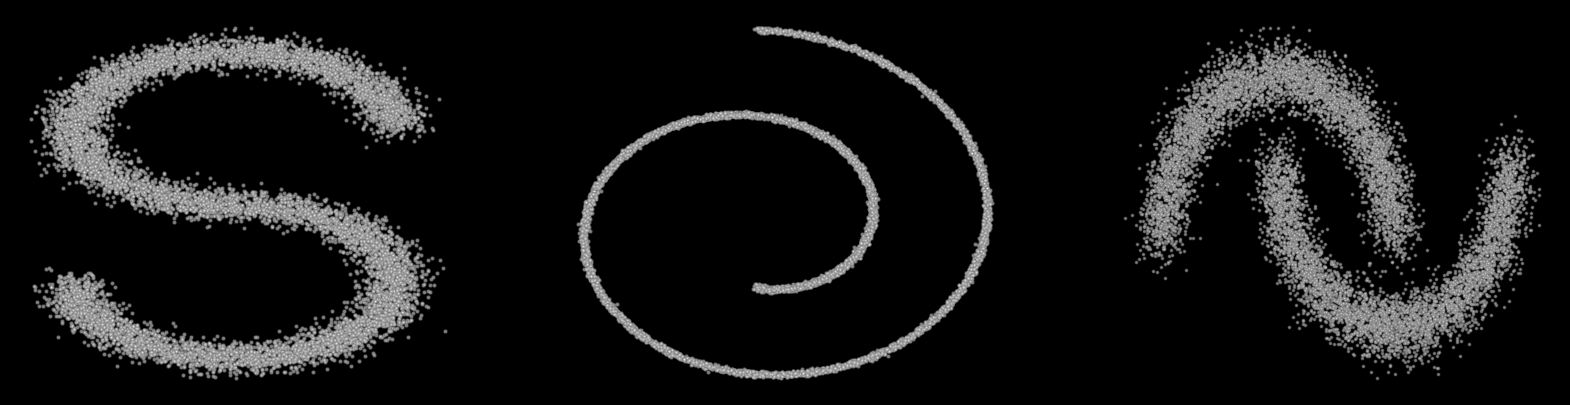

In [12]:
hdr_plot_style()
swiss_roll, _ = make_swiss_roll(10**4,noise=0.1)
swiss_roll = swiss_roll[:, [0, 2]]/10.0

s_curve, _= make_s_curve(10**4, noise=0.1)
s_curve = s_curve[:, [0, 2]]/10.0

moons, _ = make_moons(10**4, noise=0.1)

data = s_curve.T

fig,axes = plt.subplots(1,3,figsize=(20,5))

axes[0].scatter(*data, alpha=0.5, color='white', edgecolor='gray', s=5);
axes[0].axis('off')

data = swiss_roll.T
axes[1].scatter(*data, alpha=0.5, color='white', edgecolor='gray', s=5);
axes[1].axis('off')
dataset = torch.Tensor(data.T).float()

data = moons.T
axes[2].scatter(*data, alpha=0.5, color='white', edgecolor='gray', s=3);
axes[2].axis('off')

# dataset = torch.Tensor(data.T).float()

Reminder, that we want model forward propagation of noise and the amount of noise (in possition) is controlled by parameter $\beta_t$, which differs over time.
$q(x_t | x_{t-1}) = N(x_{t} ; \sqrt{1 - \beta_t} x_{t-1}, \beta_t)$

In [17]:
num_steps = 221
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=num_steps, start=1e-5, end=0.5e-2)
print("The first 10 betas: {}".format(betas[:10]))


alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

The first 10 betas: tensor([2.2338e-05, 2.3028e-05, 2.3757e-05, 2.4526e-05, 2.5337e-05, 2.6194e-05,
        2.7099e-05, 2.8054e-05, 2.9063e-05, 3.0127e-05])


In [21]:
def q_x(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

### Adding noise to the original shape

First 20 iterations:

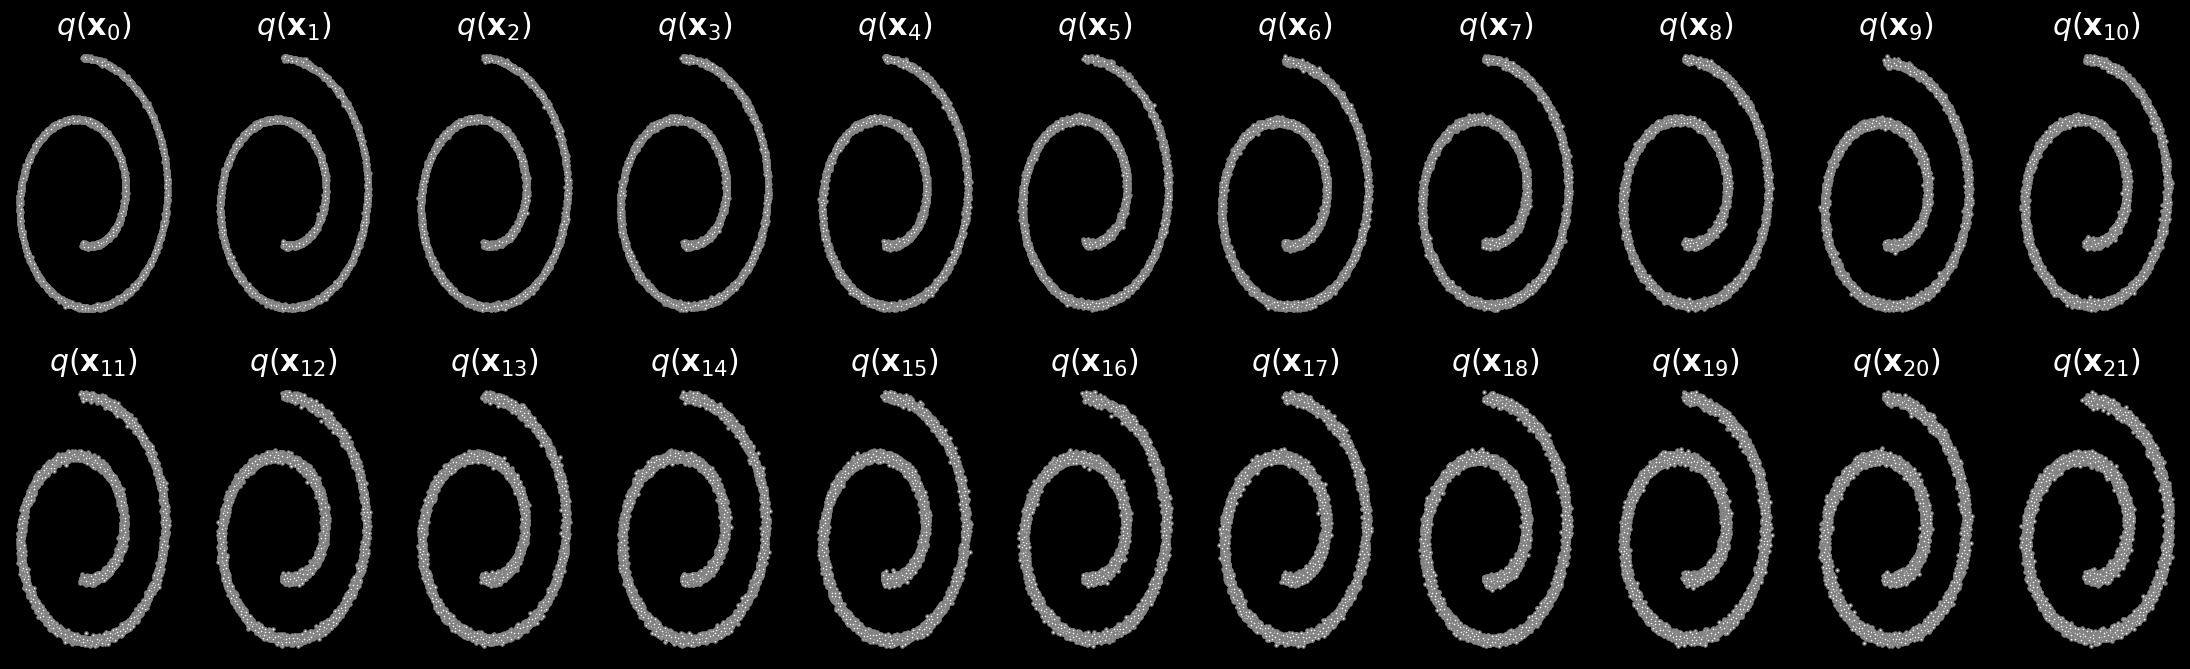

In [22]:
fig, axs = plt.subplots(2, 11, figsize=(28, 8))
for i in range(11):
    q_i = q_x(dataset, torch.tensor([i]))
    axs[0][i].scatter(q_i[:, 0], q_i[:, 1],color='white',edgecolor='gray', s=5);
    axs[0][i].set_axis_off(); axs[0][i].set_title('$q(\mathbf{x}_{'+str(i)+'})$')

for i in range(11, 22):
    q_i = q_x(dataset, torch.tensor([i]))
    axs[1][i-11].scatter(q_i[:, 0], q_i[:, 1],color='white',edgecolor='gray', s=5);
    axs[1][i-11].set_axis_off(); axs[1][i-11].set_title('$q(\mathbf{x}_{'+str(i)+'})$')


All 210 iterations: 

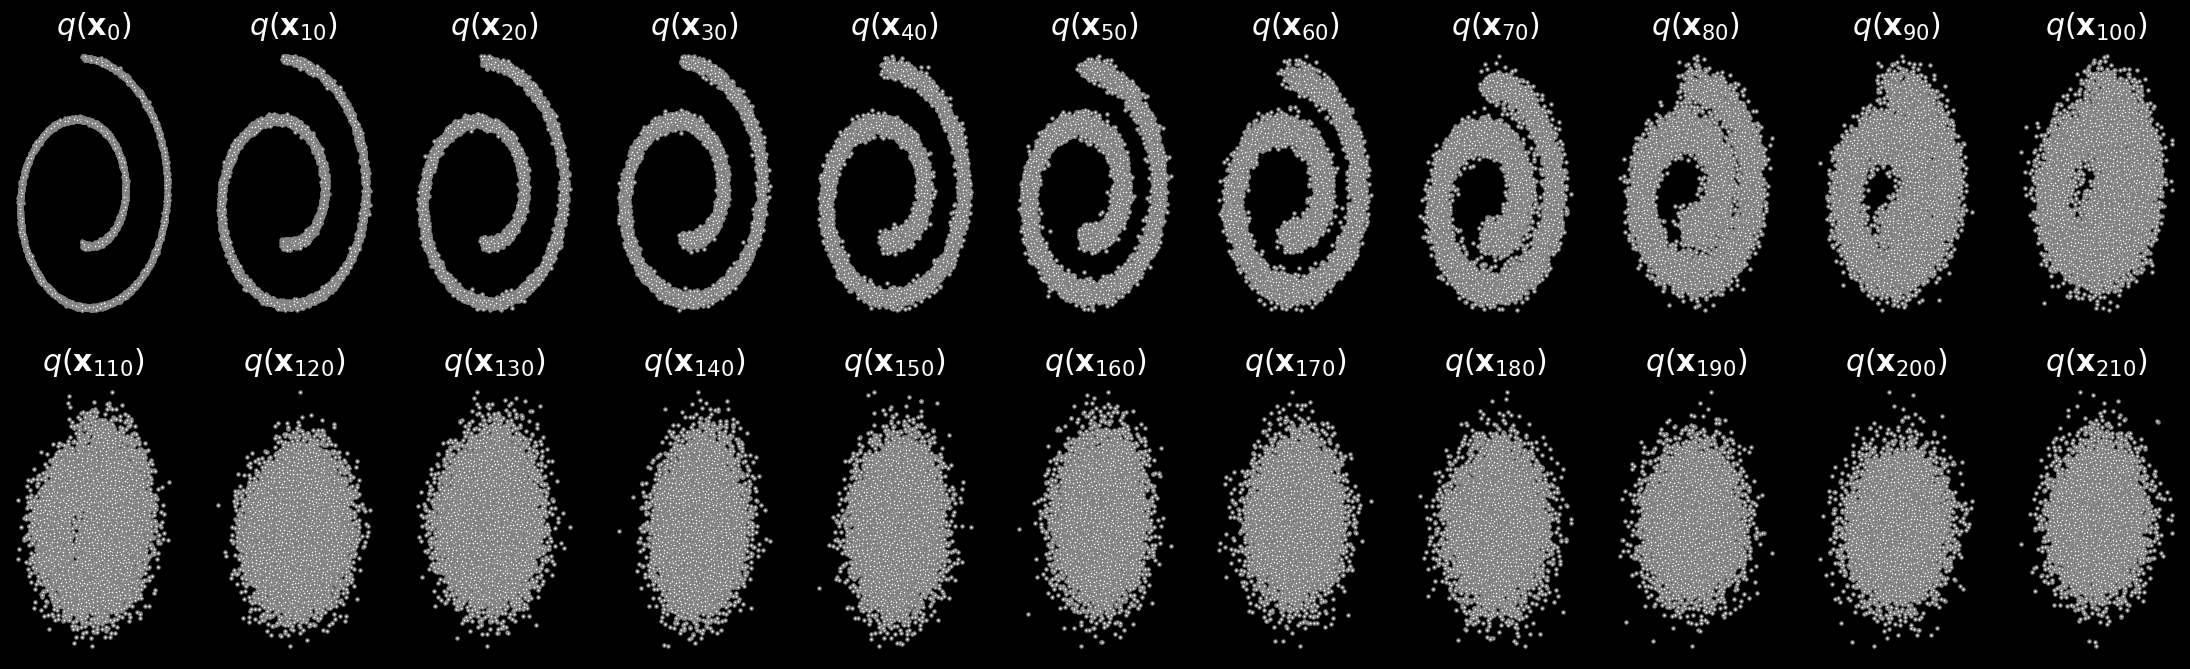

In [26]:
fig, axs = plt.subplots(2, 11, figsize=(28, 8))
for i in range(11):
    q_i = q_x(dataset, torch.tensor([i * 10]))
    axs[0][i].scatter(q_i[:, 0], q_i[:, 1],color='white',edgecolor='gray', s=5);
    axs[0][i].set_axis_off(); axs[0][i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

for i in range(11,22):
    q_i = q_x(dataset, torch.tensor([i * 10]))
    axs[1][i-11].scatter(q_i[:, 0], q_i[:, 1],color='white',edgecolor='gray', s=5);
    axs[1][i-11].set_axis_off(); axs[1][i-11].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

In [27]:
posterior_mean_coef_1 = (betas * torch.sqrt(alphas_prod_p) / (1 - alphas_prod))
posterior_mean_coef_2 = ((1 - alphas_prod_p) * torch.sqrt(alphas) / (1 - alphas_prod))
posterior_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
posterior_log_variance_clipped = torch.log(torch.cat((posterior_variance[1].view(1, 1), posterior_variance[1:].view(-1, 1)), 0)).view(-1)

def q_posterior_mean_variance(x_0, x_t, t):
    coef_1 = extract(posterior_mean_coef_1, t, x_0)
    coef_2 = extract(posterior_mean_coef_2, t, x_0)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, x_0)
    return mean, var

### Defining the Denoising Model


The model used in the training for diffusion model follows the similar patterns to a VAE network however, it is often kept much simpler and straight-forward compared to other network architectures. The input layer has the same input size as that of the data dimensions. There can be multiple hidden layers depending on the depth of the network requirements. The middle layers are linear layers with respective activation functions. The final layer is again of the same size as that of the original input layer, thereby reconstructing the original data. In the Denoising Diffusion Networks the final layer consists of two separate outputs, each dedicated to the mean and variance of the predicted probability density respectively.

The loss function of the model is following:

$L = E_p ( -\log P(x_T) - \sum_{t>0} \frac{p_\theta(x_{t-1} | x_t)}{q(x_t | x_{t-1})}$ 

this can be rewritten in terms of KL-divergence and conditional entropies:

$L = - E_p ( D_{KL} (q (x_{t-1}| x_t, x_0) \| p_\theta (x_{t-1} | x_{t}) ) + H_q(x_T | x_0) - H_q(x_1 | x_0) - H_p (x_T) $ [ (1) ](https://arxiv.org/pdf/1503.03585.pdf)



In [28]:
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out
        
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = ConditionalLinear(128, 128, n_steps)
        self.lin4 = nn.Linear(128, 2)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        x = F.softplus(self.lin3(x, y))
        return self.lin4(x)


# Exponential Moving Average Class
# Orignal source: https://github.com/acids-ircam/diffusion_models
class EMA(object):
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        module_copy = type(module)(module.config).to(module.config.device)
        module_copy.load_state_dict(module.state_dict())
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict

tensor(0.7443, grad_fn=<MeanBackward0>)
tensor(0.9373, grad_fn=<MeanBackward0>)
tensor(0.6398, grad_fn=<MeanBackward0>)
tensor(0.5979, grad_fn=<MeanBackward0>)
tensor(0.7374, grad_fn=<MeanBackward0>)
tensor(0.5818, grad_fn=<MeanBackward0>)
tensor(0.8598, grad_fn=<MeanBackward0>)
tensor(0.5480, grad_fn=<MeanBackward0>)
tensor(0.7870, grad_fn=<MeanBackward0>)
tensor(0.3649, grad_fn=<MeanBackward0>)


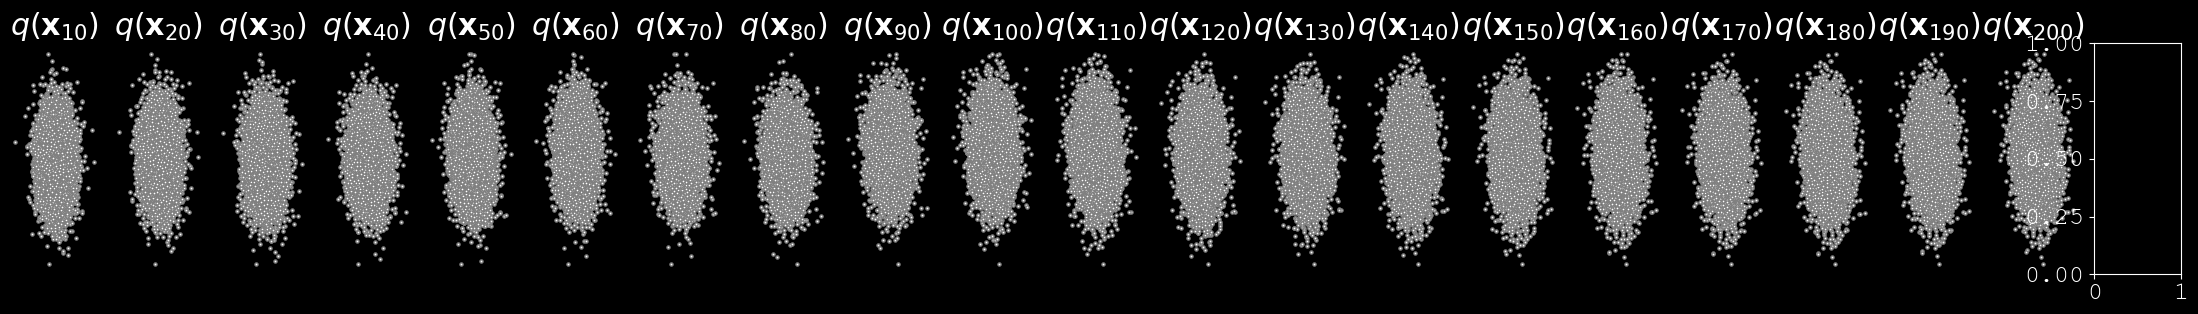

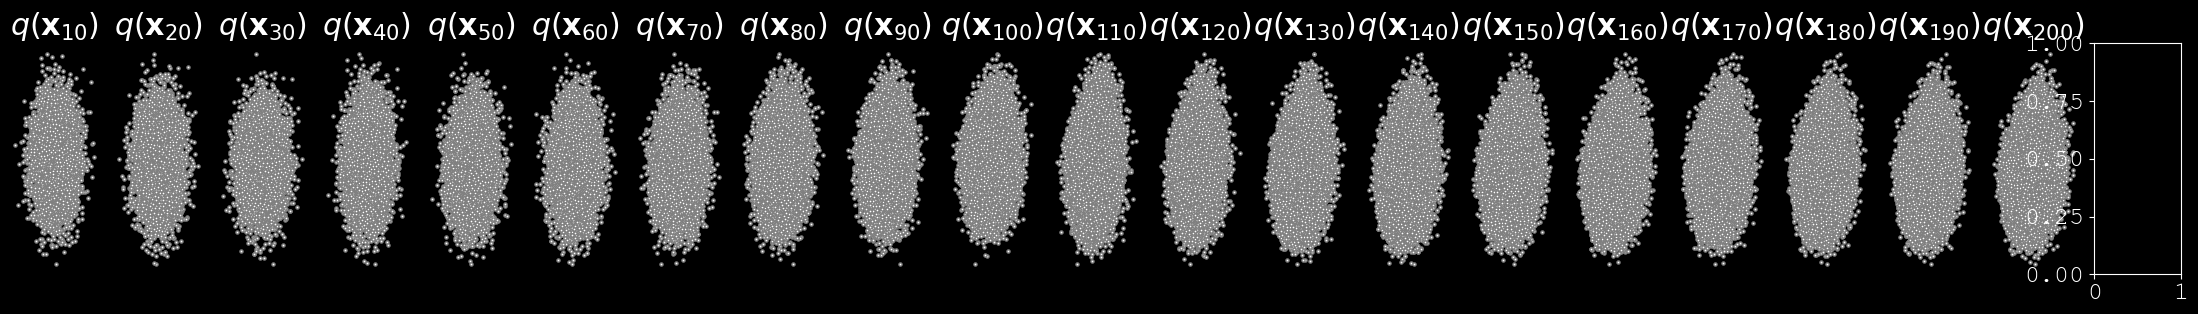

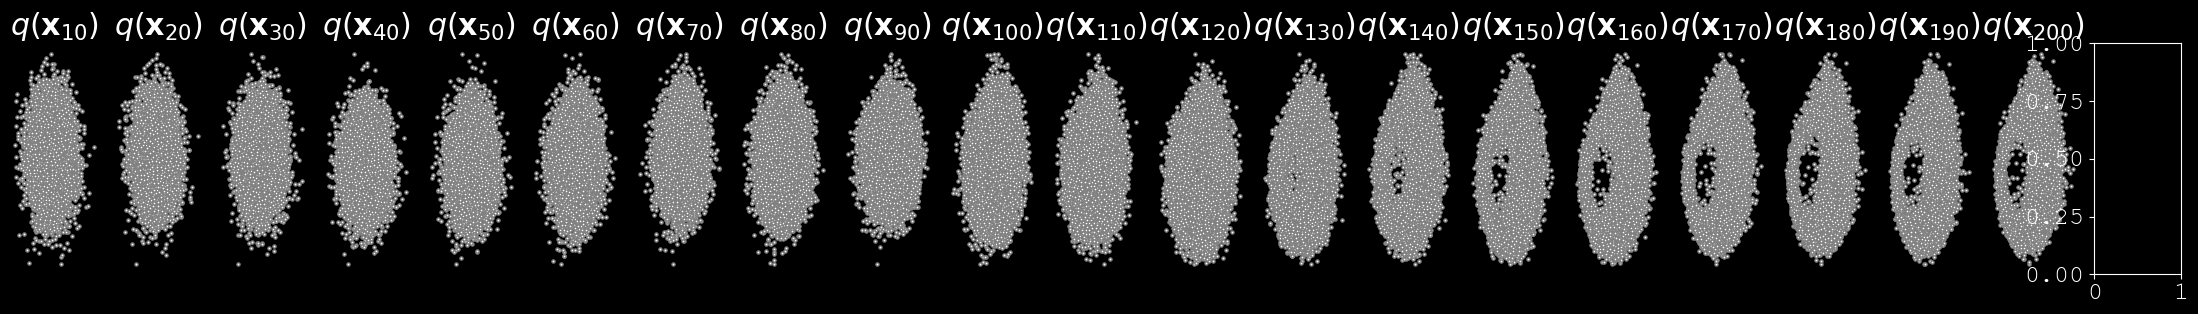

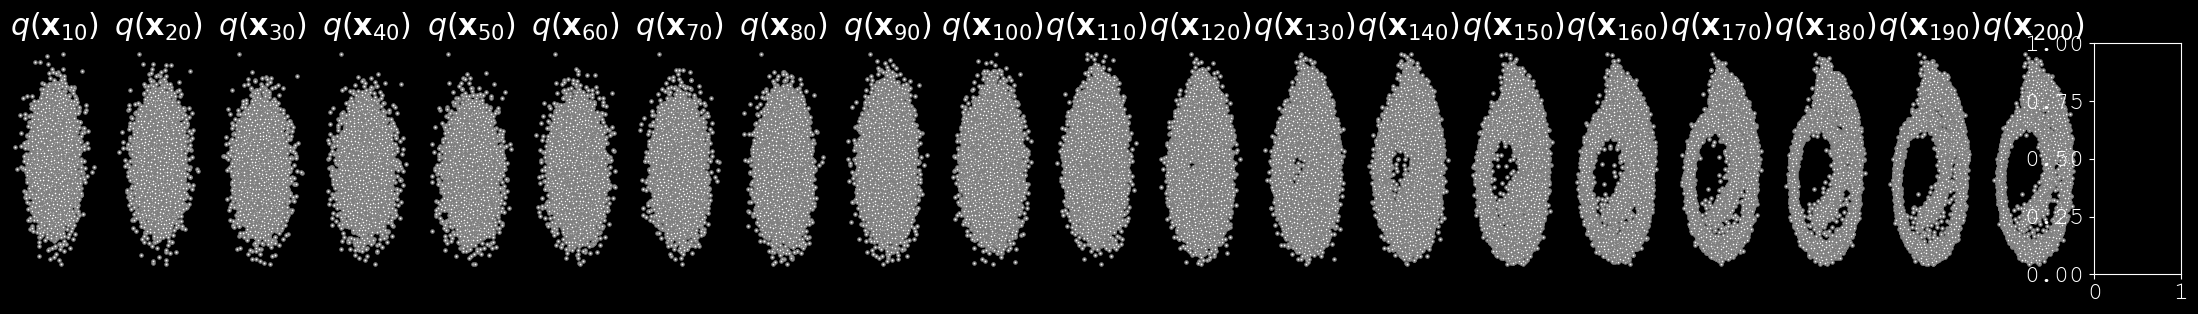

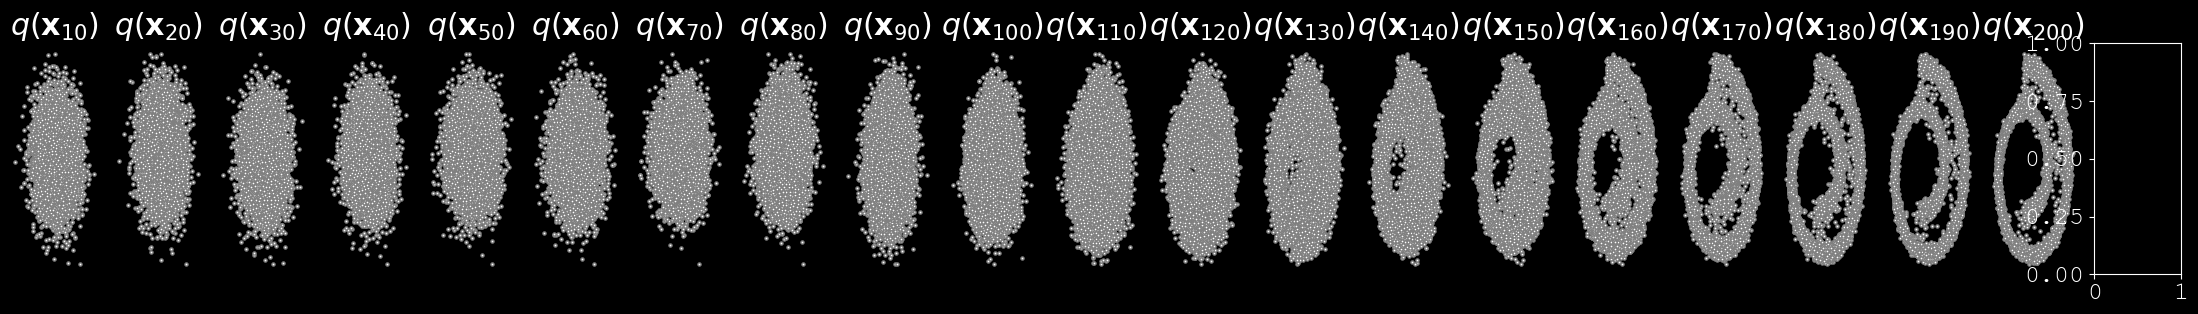

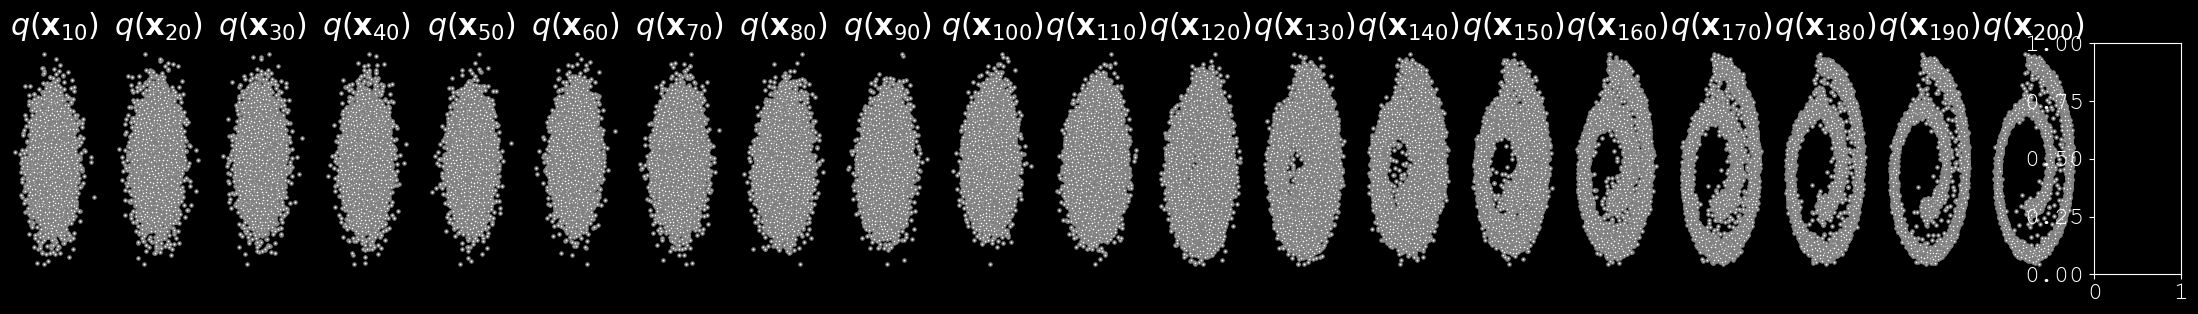

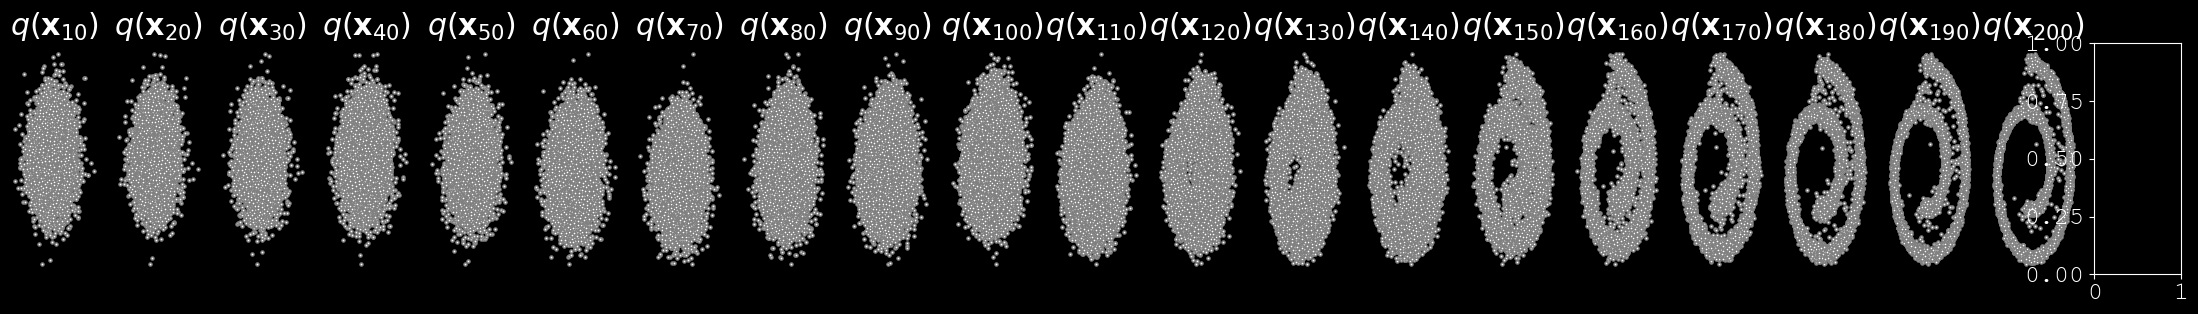

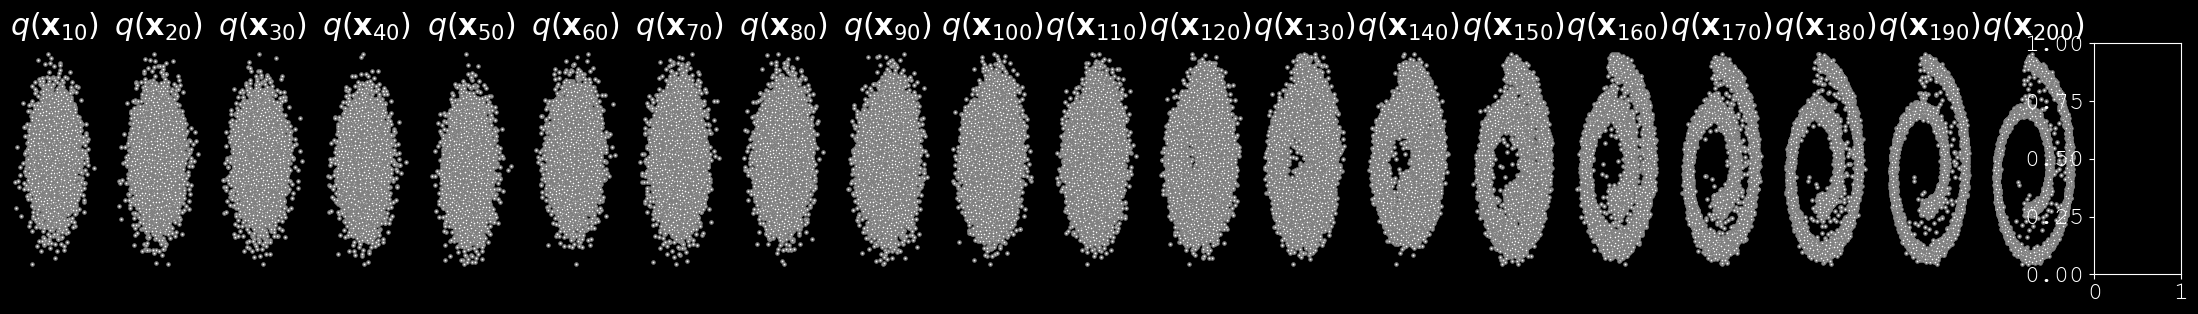

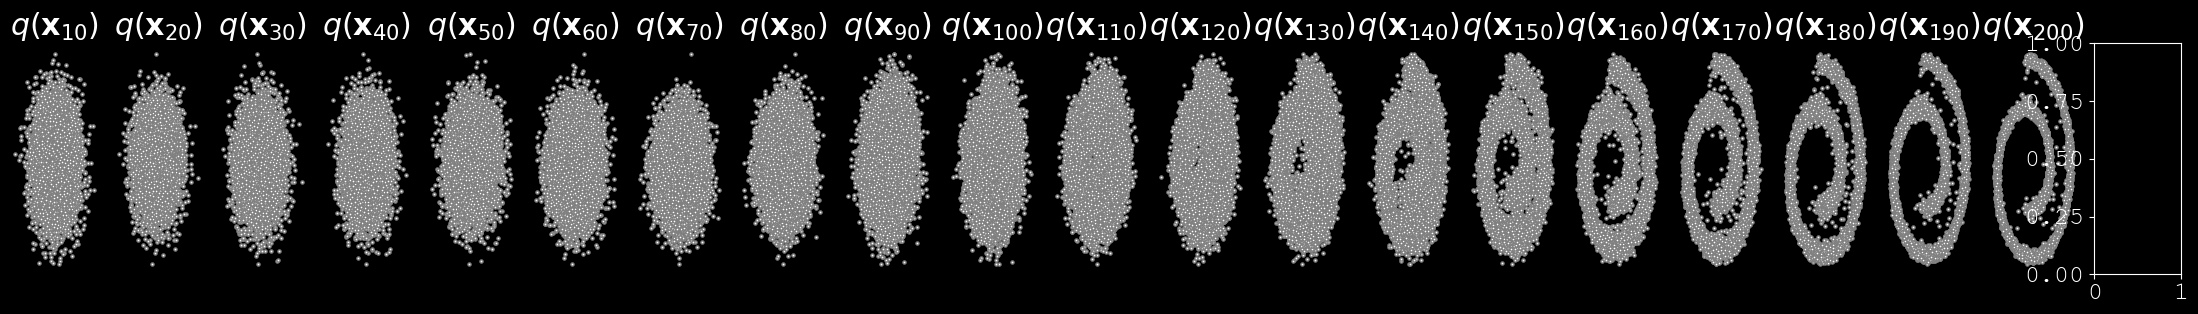

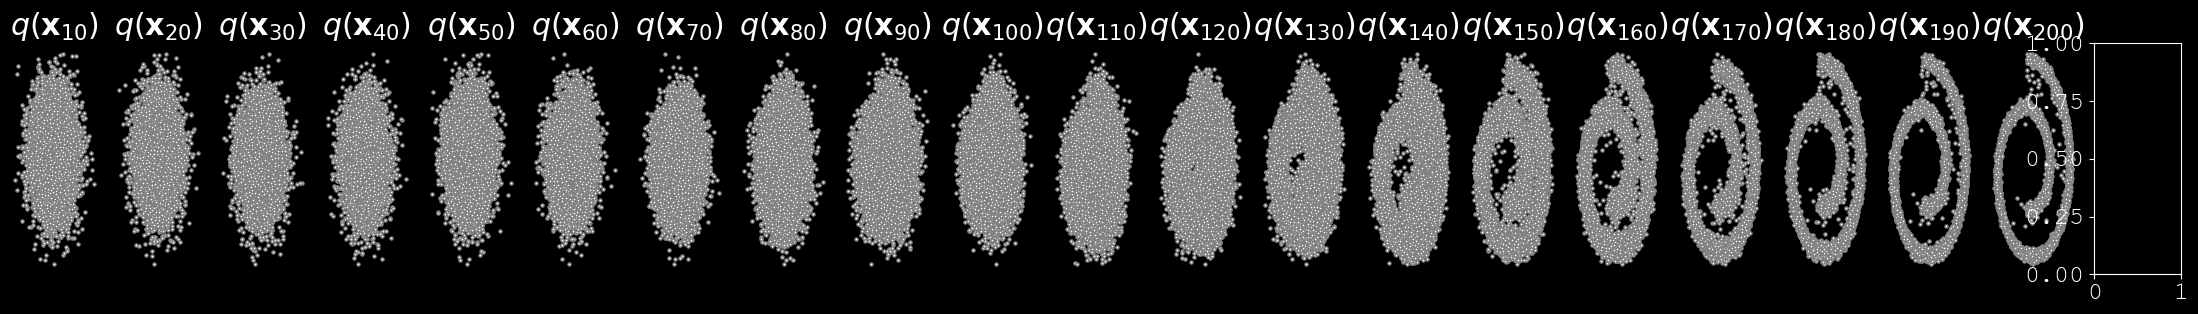

In [30]:
model = ConditionalModel(num_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Create EMA model
ema = EMA(0.9)
ema.register(model)
# Batch size
batch_size = 128
for t in range(1000):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = noise_estimation_loss(model, batch_x,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        ema.update(model)
    # Print loss
    if (t % 100 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape,num_steps,alphas,betas,one_minus_alphas_bar_sqrt)
        fig, axs = plt.subplots(1, 21, figsize=(28, 3))
        for i in range(1, 21):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1],color='white',edgecolor='gray', s=5);
            axs[i-1].set_axis_off(); 
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

In [37]:
plt.close()

# Homework

The aim of your homework is for you to explore behaviour of Denoising Diffusion Model. In your experiments, explore behaviour of the DDM depending on parameters - amount noise added in each step ($\beta_t$), number of noising steps, denoising model architecture.

Write a short report (max 3 pages) with your findings and results and documentsing them with plots and tables.

Send reports to my email - cepekmir@fit.cvut.cz with *AML Homework* as subject.